In [1]:
# --- 1. Setup and Configuration ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import mlflow
import mlflow.lightgbm
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## Configuration
Here, we define the key parameters for our experiment. You can change `WELL_TO_MODEL` to train a model for a different well.

In [2]:
# File path for the dataset
DATA_FILE_PATH = "Volve production data.xlsx"
# Choose a specific well to model. 'NO 15/9-F-1 C' has a good amount of data.
WELL_TO_MODEL = 'NO 15/9-F-1 C'
# Target variable for prediction
TARGET_VARIABLE = 'BORE_OIL_VOL'
# MLflow experiment name
MLFLOW_EXPERIMENT_NAME = "Oil_Production_Forecasting_Volve_Notebook"

## 2. Data Loading and Preparation
In this section, we load the daily production data. We then perform the following steps:
- Filter the data to keep only the records for our chosen well (`NO 15/9-F-1 C`).
- Convert the `DATEPRD` column to a proper datetime format and set it as the DataFrame index.
- Select only the relevant numeric columns that will be used as features.
- Convert all columns to numeric types, handling any conversion errors.
- Impute missing values using a forward-fill strategy, which is appropriate for time series data.

In [3]:
print("--- Loading and Preparing Data ---")
try:
    df = pd.read_excel(DATA_FILE_PATH,sheet_name='Daily Production Data')
    print(f"Successfully loaded data with shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{DATA_FILE_PATH}' was not found.")
    # In a real notebook, you might stop execution here or raise an error
    df = None

if df is not None:
    # Filter for the specific well
    df_well = df[df['WELL_BORE_CODE'] == WELL_TO_MODEL].copy()
    print(f"Filtered for well '{WELL_TO_MODEL}'. Shape: {df_well.shape}")

    # --- Data Cleaning ---
    df_well['DATEPRD'] = pd.to_datetime(df_well['DATEPRD'])
    df_well.set_index('DATEPRD', inplace=True)
    df_well.sort_index(inplace=True)

    # Select relevant numeric columns
    relevant_cols = [
        'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
        'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P',
        'AVG_WHT_P', 'BORE_GAS_VOL', 'BORE_WAT_VOL', TARGET_VARIABLE
    ]
    df_well = df_well[relevant_cols]

    # Convert columns to numeric
    for col in df_well.columns:
        df_well[col] = pd.to_numeric(df_well[col], errors='coerce')

    # Impute missing values
    df_well.fillna(method='ffill', inplace=True)
    df_well.fillna(method='bfill', inplace=True)

    print("\nData cleaning and type conversion complete.")
    print(f"Final shape after cleaning: {df_well.shape}")
    print(f"Missing values remaining: {df_well.isnull().sum().sum()}")

    # Display the first few rows of the cleaned data
    display(df_well.head())
    display(df_well.describe())

--- Loading and Preparing Data ---
Successfully loaded data with shape: (15634, 24)
Filtered for well 'NO 15/9-F-1 C'. Shape: (746, 24)

Data cleaning and type conversion complete.
Final shape after cleaning: (746, 11)
Missing values remaining: 0


C:\Users\USER\AppData\Local\Temp\ipykernel_13856\2694509406.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_well.fillna(method='ffill', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_13856\2694509406.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_well.fillna(method='bfill', inplace=True)


,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,BORE_GAS_VOL,BORE_WAT_VOL,BORE_OIL_VOL
DATEPRD,,,,,,,,,,,
2014-04-07,0.0,0.00000,0.00000,0.00000,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0
2014-04-08,0.0,0.00000,0.00000,0.00000,0.0,1.003059,0.00000,0.00000,0.0,0.0,0.0
2014-04-09,0.0,0.00000,0.00000,0.00000,0.0,0.979008,0.00000,0.00000,0.0,0.0,0.0
2014-04-10,0.0,0.00000,0.00000,0.00000,0.0,0.545759,0.00000,0.00000,0.0,0.0,0.0
2014-04-11,0.0,310.37614,96.87589,277.27826,0.0,1.215987,33.09788,10.47992,0.0,0.0,0.0


,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,BORE_GAS_VOL,BORE_WAT_VOL,BORE_OIL_VOL
count,746.000000,746.000000,746.000000,746.000000,746.0,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,13.382752,245.674079,104.503343,191.765949,0.0,29.598451,53.908130,40.409048,35443.590617,277.885241,238.216260
std,11.661552,34.438126,9.250573,38.040465,0.0,25.483084,32.967224,26.115978,40154.617232,355.827480,275.735496
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,220.797733,101.267893,169.274479,0.0,0.024879,32.183797,11.218398,0.000000,0.000000,0.000000
50%,24.000000,240.225905,107.817210,182.845279,0.0,46.546068,43.263146,53.302970,30850.565000,77.045000,200.685000
75%,24.000000,271.140482,108.139340,205.515991,0.0,51.153705,74.800139,62.364420,57112.840000,507.932500,384.605000
max,25.000000,313.870580,108.502178,305.975910,0.0,93.635429,133.592510,83.420484,221707.310000,1645.080000,1549.810000


In [4]:
df = pd.read_excel(DATA_FILE_PATH)

## 3. Feature Engineering
The model's performance heavily depends on the quality of its features. Here, we create several new features from our existing data:
- **Time-based Features:** `year`, `month`, `dayofyear`, `dayofweek`. These help the model capture seasonality.
- **Lag Features:** The oil production from 1, 7, and 14 days ago. This helps the model understand the auto-regressive nature of the time series.
- **Rolling Window Features:** The mean and standard deviation of oil production over 7, 14, and 30-day windows. These capture recent trends and volatility.

In [5]:
print("\n--- Performing Feature Engineering ---")
df_feat = df_well.copy()

# Time-based features
df_feat['year'] = df_feat.index.year
df_feat['month'] = df_feat.index.month
df_feat['dayofyear'] = df_feat.index.dayofyear
df_feat['dayofweek'] = df_feat.index.dayofweek

# Lag features for the target variable
for lag in [1, 7, 14]:
    df_feat[f'{TARGET_VARIABLE}_lag_{lag}'] = df_feat[TARGET_VARIABLE].shift(lag)

# Rolling window features for the target variable
for window in [7, 14, 30]:
    df_feat[f'{TARGET_VARIABLE}_roll_mean_{window}'] = df_feat[TARGET_VARIABLE].rolling(window=window).mean()
    df_feat[f'{TARGET_VARIABLE}_roll_std_{window}'] = df_feat[TARGET_VARIABLE].rolling(window=window).std()

# Drop NaNs created by lags and rolling windows
df_feat.dropna(inplace=True)

print("Feature engineering complete.")
print(f"Shape after feature engineering: {df_feat.shape}")
print("\nFeatures created:", [col for col in df_feat.columns if col not in df_well.columns])
display(df_feat.head())


--- Performing Feature Engineering ---
Feature engineering complete.
Shape after feature engineering: (717, 24)

Features created: ['year', 'month', 'dayofyear', 'dayofweek', 'BORE_OIL_VOL_lag_1', 'BORE_OIL_VOL_lag_7', 'BORE_OIL_VOL_lag_14', 'BORE_OIL_VOL_roll_mean_7', 'BORE_OIL_VOL_roll_std_7', 'BORE_OIL_VOL_roll_mean_14', 'BORE_OIL_VOL_roll_std_14', 'BORE_OIL_VOL_roll_mean_30', 'BORE_OIL_VOL_roll_std_30']


,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,BORE_GAS_VOL,BORE_WAT_VOL,...,dayofweek,BORE_OIL_VOL_lag_1,BORE_OIL_VOL_lag_7,BORE_OIL_VOL_lag_14,BORE_OIL_VOL_roll_mean_7,BORE_OIL_VOL_roll_std_7,BORE_OIL_VOL_roll_mean_14,BORE_OIL_VOL_roll_std_14,BORE_OIL_VOL_roll_mean_30,BORE_OIL_VOL_roll_std_30
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2014-05-06,24.00000,225.902478,107.860220,154.950860,0.0,49.005582,70.951617,58.882811,144950.15,0.0,...,1,946.12,1279.46,631.47,1067.982857,111.886197,1197.232857,174.091804,579.757667,609.587776
2014-05-07,24.00000,225.768349,107.838165,155.058536,0.0,47.920400,70.709813,57.425642,135000.24,0.0,...,2,1002.83,1225.62,1166.46,1025.081429,98.093046,1180.007857,188.688733,610.601333,602.611213
2014-05-08,24.00000,225.686923,107.821048,155.141902,0.0,47.296948,70.545020,57.655958,127564.51,0.0,...,3,925.31,1212.90,1549.81,982.361429,60.625730,1134.582857,168.257523,641.063333,593.713090
2014-05-09,13.83334,227.797838,107.599455,156.852217,0.0,29.133587,70.945621,55.955302,24322.70,0.0,...,4,913.86,1074.04,1248.70,854.184286,302.095865,1058.018571,302.590577,646.956667,587.980121
2014-05-10,24.00000,226.060915,107.683690,155.164971,0.0,48.134385,70.895943,57.373779,52162.58,0.0,...,5,176.80,1044.17,1345.78,839.901429,293.867863,1029.333571,292.064856,678.429667,577.329653


## 4. Model Training, Tuning, and Logging
This is the core modeling step.
- **Data Splitting:** We split the data into a training and a testing set. Crucially, we do a chronological split to ensure we are forecasting the future, not peeking into it.
- **Hyperparameter Tuning:** We use `GridSearchCV` with `TimeSeriesSplit` to find the best hyperparameters for our LightGBM model in a way that respects the temporal order of the data.
- **MLflow Logging:** We start an MLflow run to track our experiment. We log:
    - The well code and target variable.
    - The best hyperparameters found by GridSearchCV.
    - The evaluation metrics (MAE and RMSE) on the test set.
    - A feature importance plot as an artifact.
    - The final, trained model itself, with a signature that defines its input and output schema.


--- Model Training and Logging ---
Training data shape: (534, 23)
Test data shape: (183, 23)
MLflow Run Started. Run ID: bc79f9adb1c3474cb17952947f37a4ba

Starting GridSearchCV for hyperparameter tuning...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 22
[LightGBM] [Info] Start training from score 262.085955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

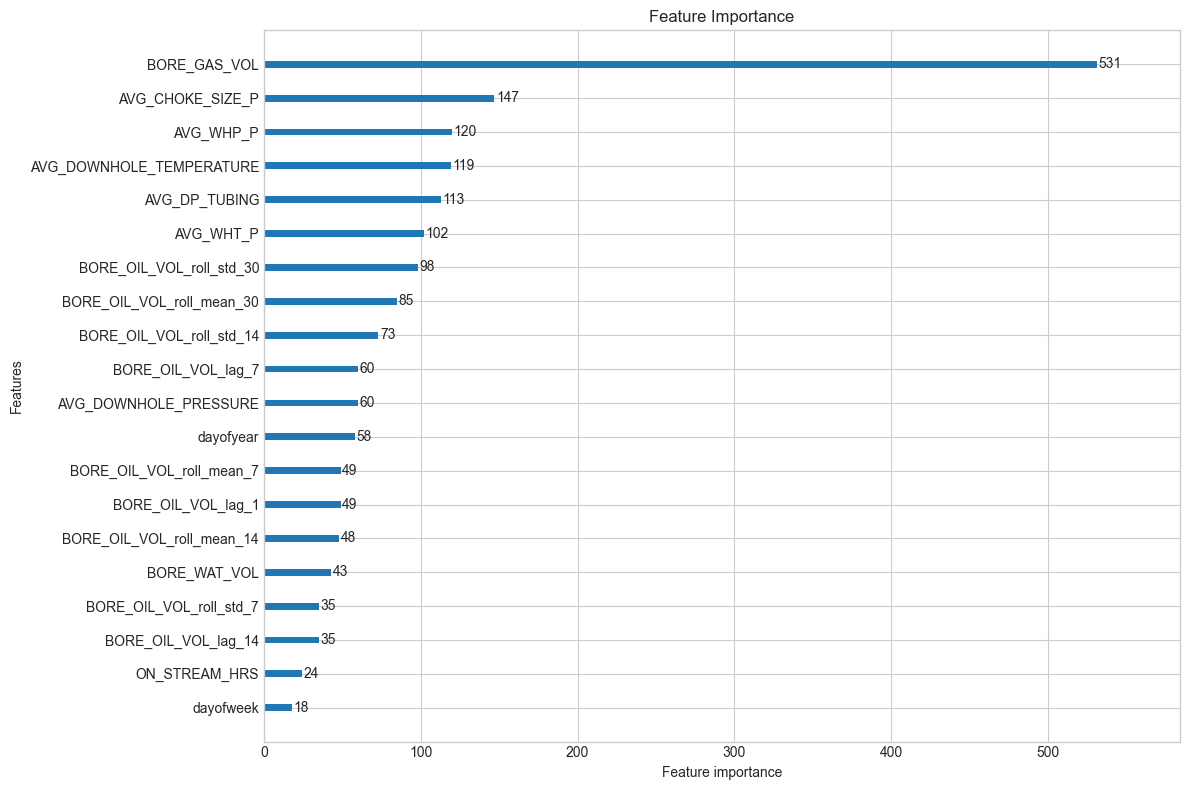

Logged actual vs. predicted time series plot.


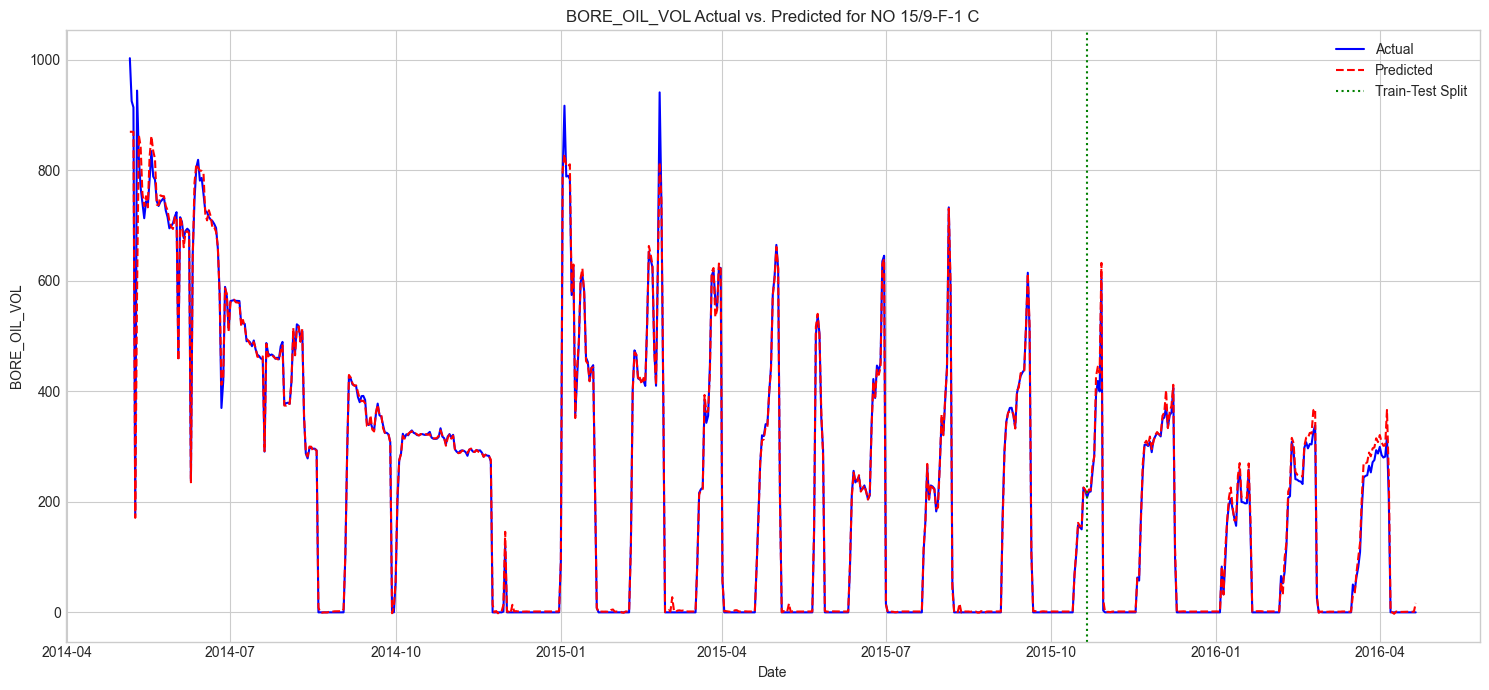

c:\Users\USER\anaconda3\envs\venv1\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/07/30 09:49:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged model with signature.

--- Model training complete and logged to MLflow experiment 'Oil_Production_Forecasting_Volve_Notebook' ---


Registered model 'oil-prod-forecast-NO 15_9-F-1 C' already exists. Creating a new version of this model...
Created version '3' of model 'oil-prod-forecast-NO 15_9-F-1 C'.


: 

In [ ]:

print("\n--- Model Training and Logging ---")

# Split data into features (X) and target (y)
X = df_feat.drop(TARGET_VARIABLE, axis=1)
y = df_feat[TARGET_VARIABLE]

# Chronological train-test split for time series (last 6 months for testing)
split_date = X.index.max() - pd.DateOffset(months=6)
X_train, X_test = X.loc[X.index <= split_date], X.loc[X.index > split_date]
y_train, y_test = y.loc[y.index <= split_date], y.loc[y.index > split_date]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Set up MLflow
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
with mlflow.start_run() as run:
    run_id = run.info.run_id
    print(f"MLflow Run Started. Run ID: {run_id}")
    mlflow.log_param("well_code", WELL_TO_MODEL)
    mlflow.log_param("target_variable", TARGET_VARIABLE)

    # --- Hyperparameter Tuning with GridSearchCV ---
    tscv = TimeSeriesSplit(n_splits=3)
    lgbm = lgb.LGBMRegressor(random_state=42)

    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [20, 31],
        'max_depth': [-1, 10]
    }

    print("\nStarting GridSearchCV for hyperparameter tuning...")
    grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=tscv,
                               scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"\nBest parameters found: {best_params}")
    mlflow.log_params(best_params)

    # Train final model with best parameters
    final_model = lgb.LGBMRegressor(**best_params, random_state=42)
    final_model.fit(X_train, y_train)

    # --- Evaluation ---
    predictions = final_model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"\nTest Set MAE: {mae:.2f}")
    print(f"Test Set RMSE: {rmse:.2f}")
    mlflow.log_metric("test_mae", mae)
    mlflow.log_metric("test_rmse", rmse)

    # --- Log Artifacts ---
    # 1. Feature Importance Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    lgb.plot_importance(final_model, ax=ax, max_num_features=20)
    plt.title('Feature Importance')
    plt.tight_layout()

    plot_path = "feature_importance.png"
    fig.savefig(plot_path)
    mlflow.log_artifact(plot_path, "plots")
    os.remove(plot_path)
    print("\nLogged feature importance plot.")
    plt.show() # Display plot in the notebook

    #  Time Series Actual vs. Predicted Plot
    # Get predictions for the training set
    train_predictions = final_model.predict(X_train)

    # Create a combined series for actual values (training and test)
    actual_series = pd.concat([y_train, y_test])

    # Create a combined series for predicted values, aligning with actuals
    # Initialize with NaNs to fill selectively
    predicted_series = pd.Series(np.nan, index=actual_series.index)
    predicted_series.loc[y_train.index] = train_predictions
    predicted_series.loc[y_test.index] = predictions


    fig_ts, ax_ts = plt.subplots(figsize=(15, 7))
    ax_ts.plot(actual_series.index, actual_series, label='Actual', color='blue')
    ax_ts.plot(predicted_series.index, predicted_series, label='Predicted', color='red', linestyle='--')
    ax_ts.axvline(x=split_date, color='green', linestyle=':', label='Train-Test Split')
    ax_ts.set_title(f'{TARGET_VARIABLE} Actual vs. Predicted for {WELL_TO_MODEL}')
    ax_ts.set_xlabel('Date')
    ax_ts.set_ylabel(TARGET_VARIABLE)
    ax_ts.legend()
    ax_ts.grid(True)
    plt.tight_layout()

    ts_plot_path = "actual_vs_predicted_time_series.png"
    fig_ts.savefig(ts_plot_path)
    mlflow.log_artifact(ts_plot_path, "plots")
    os.remove(ts_plot_path)
    print("Logged actual vs. predicted time series plot.")
    plt.show() # Display plot in the notebook


    # 2. Model Signature and Model Logging
    signature = infer_signature(X_train, final_model.predict(X_train))
    mlflow.lightgbm.log_model(
        lgb_model=final_model,
        artifact_path="model",
        signature=signature,
        registered_model_name=f"oil-prod-forecast-{WELL_TO_MODEL.replace('/', '_')}"
    )
    print("Logged model with signature.")
    print(f"\n--- Model training complete and logged to MLflow experiment '{MLFLOW_EXPERIMENT_NAME}' ---")

## 5. Conclusion

The pipeline has successfully completed.

To see all the logged information, start the MLflow UI by running `mlflow ui` in your terminal from the same directory where you ran this notebook. You can then navigate to the experiment and inspect the run details.